# Requirements

In [6]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.rc('font', family='Malgun Gothic')  

pd.set_option('mode.chained_assignment', None)

## Timeline strategy

### load database, aggregate fluctuation s by s

In [14]:
database_dir_path = "D:\Projects\Richer\QuantAnalyzer\Stock\database\KOSDAQ"

df_list = []
df_name_list = []
df_fluc_list = []

for p_i, pkl in enumerate(os.listdir(database_dir_path)):
    
    print(p_i)
    df = pd.read_excel(os.path.join(database_dir_path, pkl), index_col=0)
    # display(df.head())
    # break
    
    try:
        old_cols = ['시가', '고가', '저가', '현재가', '거래량']
        df = df[old_cols]
        df.columns = ['open', 'high', 'low', 'close', 'volume']
    except:
        pass

    # print(len(df))
    
    price_fluctuation = df.close / df.close.shift(1)  
    price_fluctuation.name = p_i
    
    df_list.append(df)
    df_name_list.append(pkl)
    df_fluc_list.append(price_fluctuation)
    
    # if p_i > 20:
    #     break
    
                  
    clear_output(wait=True)

1704


### get top rank, alignment by fluctuation ranking.

In [15]:
df_flucs_rank = pd.concat(df_fluc_list, axis=1).rank(ascending=False, method='first', axis=1)

top_rank = 10
df_buy = df_flucs_rank <= top_rank

In [ ]:
df_buy
# df_flucs_rank

### adj. strategy

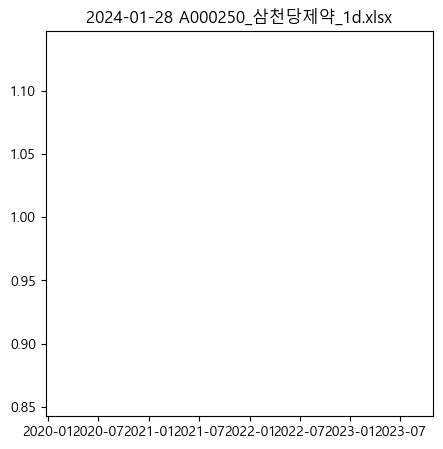

In [43]:
take_profit = 1.1  # 10%
stop_loss = 0.95   # -5%

fees = 0.00015 + 0.00015  # 0.015% 수수료
fee_trade = 0.0018

save_excel = 0
save_path = database_dir_path.replace('database', 'result')
os.makedirs(save_path, exist_ok=True)

show_plot = 1

symbol_names = []
buys  = []
holds = []
sells = []
profits = []
profit_cums = []


col_i = 0  # symbol_index, for test.
for col_i, (_, df_name) in enumerate(zip(df_fluc_list, df_name_list)):

    print(col_i, end='\r')
    
    en_ex_total = []
    en_ex = []
    
    # 1. get symbol name from file name.
    # print(df_name)  # 2024-01-28 A000250_삼천당제약_1d.xlsx
    symbol_name = df_name.split(' ')[1].split('_')[1]
    # print(symbol_name)
    # break
    
    # 2. we will use symbol name as index.
    symbol_names.append(symbol_name)
    

    for row, signal in zip(df_list[col_i].iterrows(), df_buy.iloc[:, col_i]):

        en_ex_len = len(en_ex)
        
        # buy_ts = []
        # sell_ts = []
        # hold_ts = []
        

        # a. check buy signal.
            # i. buying symbol multiple times invalid.
        if signal and en_ex_len == 0:
            en_ex.append(row[-1].name)
            en_ex.append(row[-1]['close'])
            hold_ts = []
            
        # b. check sell signal.
        if en_ex_len > 0:

            exit_done = 0

            # i. take_profit
            if row[-1]['high'] / en_ex[1] >= take_profit:
                profit = take_profit * (1 - fees - fee_trade) # 증권거래세 등(0.18%)
                exit_done = 1
            elif row[-1]['low'] / en_ex[1] <= stop_loss:
                profit = stop_loss * (1 - fees)
                exit_done = -1

            if exit_done:
                en_ex.append(row[-1].name)
                en_ex.append(exit_done)
                en_ex.append(profit)
                en_ex.append(hold_ts)
                en_ex_total.append(en_ex)
                en_ex = []
            else:
                hold_ts.append(row[-1].name)
                # en_ex.append(row[-1].name)
                # en_ex.append(exit_done)
                # en_ex.append(np.nan)
                


    en_ex_total_arr = np.array(en_ex_total, dtype=object)

    # 3. initialization
    df_list[col_i]['buy'] = np.nan
    df_list[col_i]['hold'] = np.nan
    df_list[col_i]['sell'] = np.nan
    df_list[col_i]['profit'] = np.nan
    df_list[col_i]['profit_cum'] = 1

    # 4. enlist trade info.
    if len(en_ex_total_arr) > 0:
        df_list[col_i]['buy'].loc[en_ex_total_arr[:, 0]] = 1
        df_list[col_i]['hold'].loc[np.hstack(en_ex_total_arr[:, -1])] = 1
        df_list[col_i]['sell'].loc[en_ex_total_arr[:, 2]] = en_ex_total_arr[:, 3]
        df_list[col_i]['profit'].loc[en_ex_total_arr[:, 2]] = en_ex_total_arr[:, 4]
        df_list[col_i]['profit_cum'].loc[en_ex_total_arr[:, 2]] = en_ex_total_arr[:, 4]
        # df_list[col_i]['profit_cum'] = np.cumprod(df_list[col_i]['profit'])
        df_list[col_i]['profit_cum'] = np.cumprod(df_list[col_i]['profit_cum'])
        
    buys.append(df_list[col_i]['buy']) # .to_numpy()
    holds.append(df_list[col_i]['hold']) # .to_numpy()
    sells.append(df_list[col_i]['sell']) # .to_numpy()
    profits.append(df_list[col_i]['profit']) # .to_numpy()
    profit_cums.append(df_list[col_i]['profit_cum']) # .to_numpy()

    # display(df_list[col_i])

    if show_plot:
        plt.figure(figsize=(5,5))
        plt.plot(df_list[col_i]['profit_cum'])
        plt.title(df_name_list[col_i])
        plt.show()
    
    if save_excel:
        df_list[col_i].to_excel(os.path.join(save_path, '{}'.format(df_name_list[col_i])), index=True)
    
    
    # print(len(df_list[col_i]['buy'].to_numpy()))
    # print(len(df_list[col_i]))
    break

In [40]:
"""
aggregate traded data.
"""
pos_buy = pd.DataFrame(data=buys, index=symbol_names).transpose()
pos_hold = pd.DataFrame(data=holds, index=symbol_names).transpose()
pos_sell = pd.DataFrame(data=sells, index=symbol_names).transpose()
pos_profit = pd.DataFrame(data=profits, index=symbol_names).transpose()
pos_profit_cum = pd.DataFrame(data=profit_cums, index=symbol_names).transpose()

In [ ]:
profits_list = []
profits_cum_list = []

for ts_i in range(len(pos_buy)):
    
    buy_info = pos_buy.iloc[ts_i]
    hold_info = pos_hold.iloc[ts_i]
    sell_info = pos_sell.iloc[ts_i]
    profit_info = pos_profit.iloc[ts_i]
    profit_cum_info = pos_profit_cum.iloc[ts_i]    

    # 1. Take traded symbols.
    buy_on = buy_info[buy_info == 1]
    hold_on = hold_info[hold_info == 1]
    sell_on = sell_info[(sell_info == 1) | (sell_info == -1)]
    profit_on = np.cumprod(profit_info[~pd.isnull(profit_info).to_numpy()])
    if len(profit_on) == 0:
        profit_on = 1
    else:
        profit_on = profit_on[-1]
    profit_cum_on = np.cumprod(profit_cum_info[~pd.isnull(profit_cum_info)].to_numpy())[-1]
    # print("(profit_info[~pd.isnull(profit_info)] :", profit_info[~pd.isnull(profit_info)].to_numpy())
    # print("(profit_cum_info[~pd.isnull(profit_cum_info)] :", profit_cum_info[~pd.isnull(profit_cum_info)].to_numpy())
    # break
    
    print("기준일 :", buy_on.name)
    print("매수 종목 :", buy_on.index.values)
    print("보유 종목 :", hold_on.index.values)
    print("매도 종목 :", sell_on.index.values)
    print("최종수익률 (종목별) : {:.3f}%".format(profit_on))
    print("누적수익률 : {:.3f}%".format(profit_cum_on))
    print()

    profits_list.append(profit_on)
    profits_cum_list.append(profit_cum_on)
    
    # break
    if ts_i > 10:
        break

In [42]:
# print(np.cumprod(profits_list)[-1])
# profits_cum_list[-1]

np.vstack([profits_list, np.cumprod(profits_list), profits_cum_list]).T#.astype(float) #.shape
# pd.DataFrame(data=

array([[ 1.        ,  1.        ,  1.        ],
       [ 1.        ,  1.        ,  1.        ],
       [ 1.30949977,  1.30949977,  1.30949977],
       [ 0.9402852 ,  1.23130325,  0.9402852 ],
       [ 1.35158926,  1.66421625,  1.35158926],
       [ 1.24365157,  2.06970516,  1.24365157],
       [ 1.13297158,  2.34491713,  1.13297158],
       [ 1.35158926,  3.16936481,  1.48362602],
       [ 1.73198669,  5.48929766,  1.73198669],
       [ 1.13297158,  6.21921824,  1.29649763],
       [ 1.35158926,  8.40582861,  1.54666923],
       [ 1.36514389, 11.4751656 ,  1.29649763]])

## backtrader

In [ ]:
from datetime import datetime
import backtrader as bt

# Create a subclass of Strategy to define the indicators and logic

class SmaCross(bt.Strategy):
    # list of parameters which are configurable for the strategy
    params = dict(
        pfast=10,  # period for the fast moving average
        pslow=30   # period for the slow moving average
    )

    def __init__(self):
        sma1 = bt.ind.SMA(period=self.p.pfast)  # fast moving average
        sma2 = bt.ind.SMA(period=self.p.pslow)  # slow moving average
        self.crossover = bt.ind.CrossOver(sma1, sma2)  # crossover signal

    def next(self):
        if not self.position:  # not in the market
            if self.crossover > 0:  # if fast crosses slow to the upside
                self.buy()  # enter long

        elif self.crossover < 0:  # in the market & cross to the downside
            self.close()  # close long position


cerebro = bt.Cerebro()  # create a "Cerebro" engine instance

# Create a data feed
# datalist.append(df)
data = bt.feeds.PandasData(dataname=df)

cerebro.adddata(data)  # Add the data feed

cerebro.addstrategy(SmaCross)  # Add the trading strategy
cerebro.run()  # run it all

cerebro.plot(iplot=False)  # and plot it with a single command


In [ ]:
# df# !pip list